In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import ticker
rcParams["figure.figsize"] = (10,8)
plt.style.use("science")
import eispac
from glob import glob
import sunpy
import sunpy.map
from sunpy.io.special import read_genx
from sunpy.image.coalignment import calculate_shift
import cmcrameri.cm as cmcm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch
from scipy import interpolate
from scipy import ndimage
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFitSingle, SpectrumFitRow, SpectrumFit2D
rcParams['axes.labelsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 18
rcParams['figure.figsize'] = [10,10]
rcParams['axes.linewidth'] = 2
rcParams['axes.titlesize'] = 18
from scipy.interpolate import interp1d
import astropy.constants as const
import copy
import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
data_filepath = '../../src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5'
fe_10_184_fit_file = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5"
fe_12_195_fit_file = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_12_195_119.2c-0.fit.h5"
fe_14_264_fit_file = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_14_264_787.1c-0.fit.h5"

In [9]:
aia_193_map = sunpy.map.Map("../../src/AIA/AIA20170821_125604_0193.fits")

Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


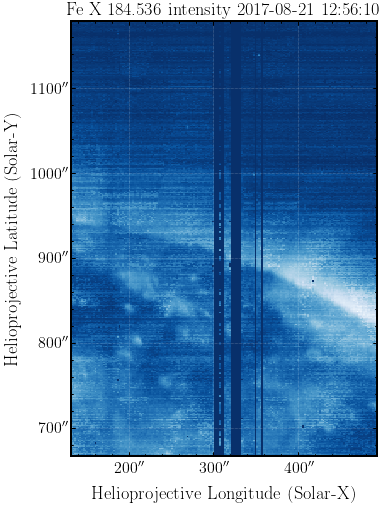

In [4]:
fe_10_184_fit_res = eispac.read_fit(fe_10_184_fit_file)
fe_10_184_inten_map = fe_10_184_fit_res.get_map(component=0, measurement='intensity')
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(projection=fe_10_184_inten_map)
fe_10_184_inten_map.plot(axes=ax)

/anaconda3/lib/python3.7/site-packages/eispac/core/eisfitresult.py:426: RuntimeWarning: invalid value encountered in true_divide
  rel_error = obs_errs/obs_cent


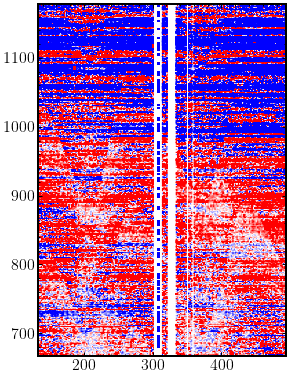

In [5]:
fe_10_184_vel = fe_10_184_fit_res.calculate_velocity(component=0,corr_method="column")
fig, ax = plt.subplots(figsize=(4,6),constrained_layout=True)
ax.imshow(fe_10_184_vel[0], origin="lower", extent=fe_10_184_fit_res.meta["extent_arcsec"],cmap="bwr_r",vmin=-10,vmax=10)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


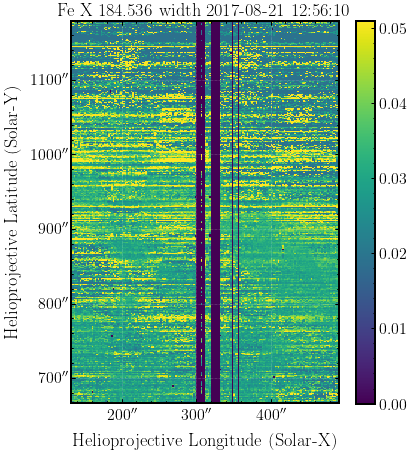

In [6]:
fe_10_184_width_map = fe_10_184_fit_res.get_map(0, 'width')
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(projection=fe_10_184_width_map)
fe_10_184_width_map.plot(axes=ax)
plt.colorbar(ax=ax,shrink=0.88)

Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_12_195_119.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


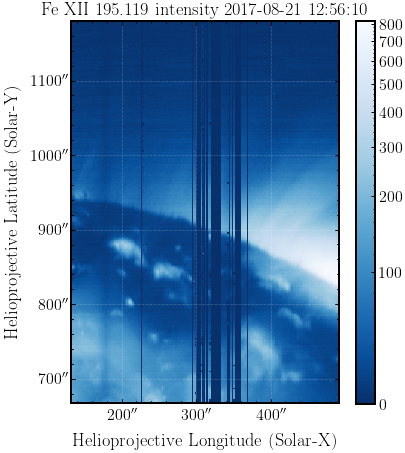

In [7]:
fe_12_195_fit_res = eispac.read_fit(fe_12_195_fit_file)
fe_12_195_inten_map = fe_12_195_fit_res.get_map(component=0, measurement='intensity')
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(projection=fe_12_195_inten_map)
fe_12_195_inten_map.plot(axes=ax)
plt.colorbar(ax=ax,shrink=0.88)

In [10]:
n_x = (aia_193_map.scale.axis1 * aia_193_map.dimensions.x)/fe_12_195_inten_map.scale.axis1
n_y = (aia_193_map.scale.axis2 * aia_193_map.dimensions.y)/fe_12_195_inten_map.scale.axis2
aia_193_map_r = aia_193_map.resample(u.Quantity([n_x, n_y]))

In [11]:
yshift, xshift = calculate_shift(aia_193_map_r.data, fe_12_195_inten_map.data)

In [12]:
reference_coord = aia_193_map_r.pixel_to_world(xshift, yshift)

In [13]:
Txshift = reference_coord.Tx - fe_12_195_inten_map.bottom_left_coord.Tx
Tyshift = reference_coord.Ty - fe_12_195_inten_map.bottom_left_coord.Ty

print(Txshift, Tyshift)

-4.09618arcsec -2.50511arcsec


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


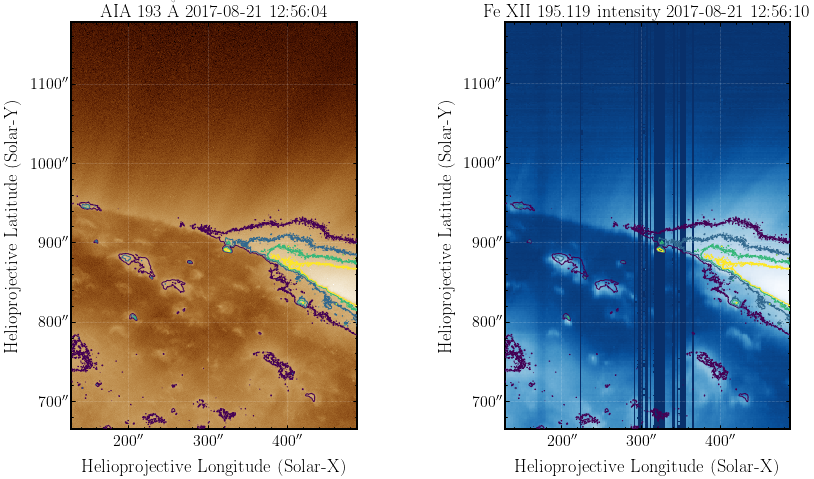

In [17]:
fe_12_195_inten_map_shifted = fe_12_195_inten_map.shift(Txshift, Tyshift)

eis_fov_width = fe_12_195_inten_map_shifted.dimensions.x*fe_12_195_inten_map_shifted.scale.axis1
eis_fov_height = fe_12_195_inten_map_shifted.dimensions.y*fe_12_195_inten_map_shifted.scale.axis2

with sunpy.coordinates.Helioprojective.assume_spherical_screen(aia_193_map.observer_coordinate,only_off_disk=True):
    eis_center = fe_12_195_inten_map_shifted.center.transform_to(aia_193_map.coordinate_frame)

    aia_193_map_crop = aia_193_map.submap(SkyCoord(eis_center.Tx - eis_fov_width/2., 
                                                        eis_center.Ty - eis_fov_height/2., frame=eis_center.frame),
                                                        width=eis_fov_width, height=eis_fov_height)

    fig = plt.figure(figsize=(12,6),constrained_layout=True)
    ax1 = fig.add_subplot(1,2,1,projection=aia_193_map_crop)
    aia_193_map_crop.plot(axes=ax1)

    ax2 = fig.add_subplot(1,2,2,projection=fe_12_195_inten_map_shifted)
    fe_12_195_inten_map_shifted.plot(axes=ax2)

    for ax_ in (ax1,ax2):
        aia_193_map_crop.draw_contours([200,300,400,500]*aia_193_map_crop.unit,axes=ax_,alpha=1,zorder=15,)

In [18]:
fe_12_195_inten_map_shifted.center

<SkyCoord (Helioprojective: obstime=2017-08-21T12:56:10.500, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21T12:56:10.500, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 6.91859397, 1.51333271e+11)>): (Tx, Ty) in arcsec
    (308.38418981, 920.8635569)>

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


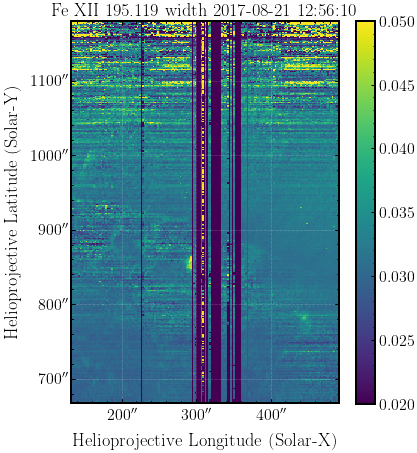

In [17]:
fe_12_195_width_map = fe_12_195_fit_res.get_map(0, 'width')
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(projection=fe_12_195_width_map)
fe_12_195_width_map.plot_settings['norm'] = ImageNormalize(vmin=0.02, vmax=0.05)
fe_12_195_width_map.plot(axes=ax)

plt.colorbar(ax=ax,shrink=0.88)

Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_14_264_787.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


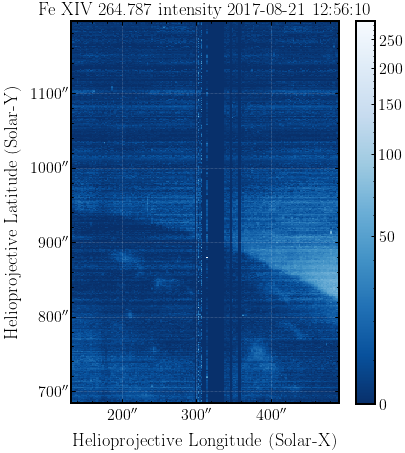

In [18]:
fe_14_264_fit_res = eispac.read_fit(fe_14_264_fit_file)
fe_14_264_inten_map = fe_14_264_fit_res.get_map(component=0, measurement='intensity')
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(projection=fe_14_264_inten_map)
fe_14_264_inten_map.plot(axes=ax)
plt.colorbar(ax=ax,shrink=0.88)

In [19]:
def interp_window_slit_tilt(data,wvl):
    data_shape = data.shape
    data_interp = np.zeros(data_shape)
    for ii in range(data_shape[0]):
        f = interp1d(wvl[ii,:],data[ii,:],kind="linear",fill_value="extrapolate")
        data_interp[ii,:] = f(wvl[0,:])
    
    return data_interp

In [20]:
data_filepath = "../../src/EIS/level1/NPCH_DB/data_eis/eis_20170821_110818.data.h5"

In [21]:
data_cube_FeX_184 = eispac.read_cube(data_filepath,184.537)

Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/NPCH_DB/data_eis/eis_20170821_110818.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/NPCH_DB/data_eis/eis_20170821_110818.head.h5
Found a wavelength 184.54 [Angstroms] in window 2
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [22]:
inst_width_bin = np.mean(data_cube_FeX_184.meta["slit_width"].reshape(-1,16),axis=1)

In [23]:
data_FeX_184 = np.zeros_like(data_cube_FeX_184.data)

In [24]:
for ii in range(180):
    data_FeX_184[:,ii,:] = interp_window_slit_tilt(data_cube_FeX_184.data[:,ii,:],data_cube_FeX_184.wavelength[:,ii,:])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


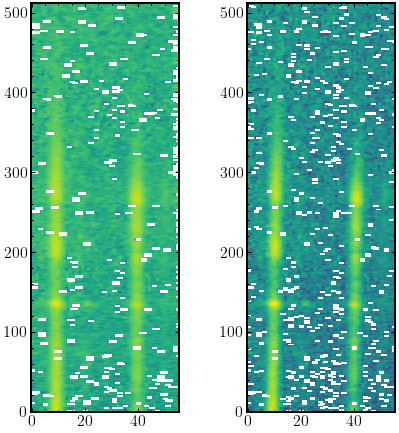

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,6),constrained_layout=True)
ax1.imshow(np.log10(data_FeX_184[:,40,:]),origin="lower",aspect=0.3)
ax2.imshow(np.log10(data_cube_FeX_184.data[:,40,:]),origin="lower",aspect=0.3)

In [26]:
data_FeX_184_mask = copy.deepcopy(data_FeX_184)
data_FeX_184_mask[np.where(data_FeX_184_mask < -50)] = np.nan

In [27]:
FeX_184_slice = slice(0,20)
FeX_184_bin = np.nanmean(data_FeX_184_mask[:,:,FeX_184_slice].reshape(-1,16,180,20),axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [28]:
FeX_184_bin_model = SpectrumFit2D(FeX_184_bin,data_cube_FeX_184.wavelength[0,:,FeX_184_slice],line_number=1,
                            line_wvl_init=[184.5],int_max_init=100,int_cont_init=0,fwhm_init=0.07,same_width=False)
FeX_184_bin_model.run_lse_mp(ncpu=1,prev_init=False,absolute_sigma=False)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:285: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diagonal(pcov))
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Doppler velocity corrected by the median of each raster.
Instrumental width corrected.


/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:1510: RuntimeWarning: invalid value encountered in sqrt
  data_to_plot = np.sqrt(data_to_plot**2 - inst_width[:,np.newaxis]**2)


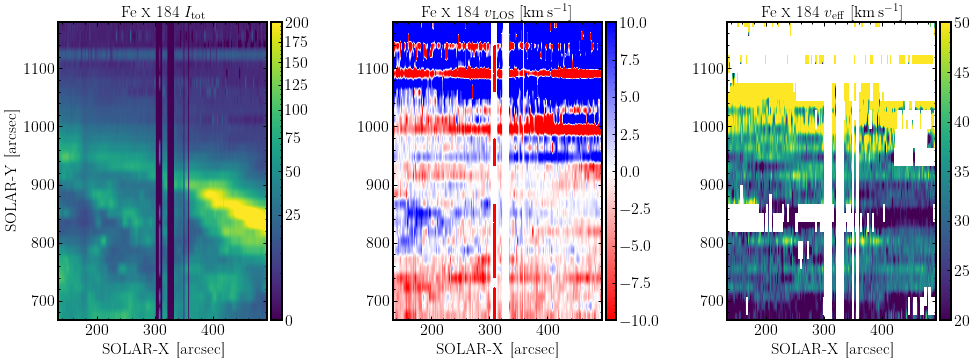

In [29]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,5),constrained_layout=True)
FeX_184_bin_model.plot_fit2d(param="int",extent=data_cube_FeX_184.meta["extent_arcsec"],vmin=0,vmax=200,scale="sqrt",
                    ax=ax1,title=r"Fe \textsc{x} 184 $I_{\rm tot}$",ylabel=r"SOLAR-Y [arcsec]",xlabel=r"SOLAR-X [arcsec]")
FeX_184_bin_model.plot_fit2d(param="vel",extent=data_cube_FeX_184.meta["extent_arcsec"],vmin=-10,vmax=10,
                    ax=ax2,ref_wvl=184.537,title=r"Fe \textsc{x} 184 $v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}$",
                    xlabel=r"SOLAR-X [arcsec]")
FeX_184_bin_model.plot_fit2d(param="veff",extent=data_cube_FeX_184.meta["extent_arcsec"],vmin=20,vmax=50,
                    ax=ax3,ref_wvl=184.537,inst_width=inst_width_bin[:],
                    title=r"Fe \textsc{x} 184 $v_{\rm eff}\ \mathrm{[km\,s^{-1}]}$",
                    xlabel=r"SOLAR-X [arcsec]")

Instrumental width corrected.
Instrumental width corrected.


/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:1512: RuntimeWarning: invalid value encountered in sqrt
  data_to_plot = np.sqrt(data_to_plot**2 - inst_width**2)


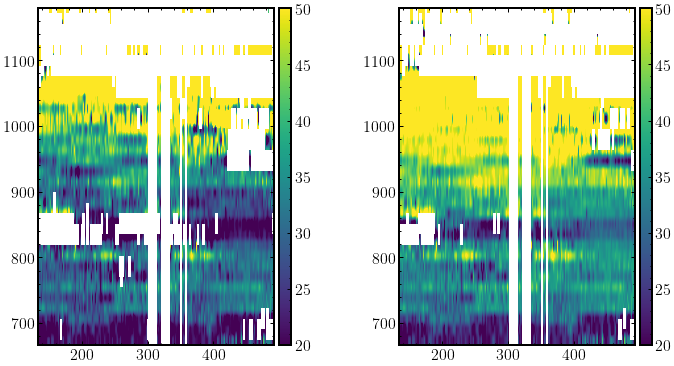

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),constrained_layout=True)
FeX_184_bin_model.plot_fit2d(param="veff",extent=data_cube_FeX_184.meta["extent_arcsec"],vmin=20,vmax=50,
                    ax=ax1,ref_wvl=184.537,inst_width=inst_width_bin)
FeX_184_bin_model.plot_fit2d(param="veff",extent=data_cube_FeX_184.meta["extent_arcsec"],vmin=20,vmax=50,
                    ax=ax2,ref_wvl=184.537,inst_width=0.064)

In [31]:
data_cube_FeXII_195 = eispac.read_cube(data_filepath,195.119)

Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/NPCH_DB/data_eis/eis_20170821_110818.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/NPCH_DB/data_eis/eis_20170821_110818.head.h5
Found a wavelength 195.12 [Angstroms] in window 6
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [40]:
north_ch_eclipse_solarx = np.array([173.05030802, 177.03795053, 181.02559305, 185.01323556,
       189.00087807, 192.98852059, 196.9761631 , 200.96380562,
       204.95144813, 208.93909064, 212.92673316, 216.91437567,
       220.90201818, 217.90462685, 221.89226936, 225.87991188,
       229.86755439, 233.8551969 , 237.84283942, 241.83048193,
       245.81812445, 249.80576696, 253.79340947, 257.78105199,
       261.7686945 , 265.75633701, 269.74397953])*u.arcsec
north_ch_eclipse_solary = np.array([949.03696581,  956.6971558 ,  964.3573458 ,  972.0175358 ,
        979.6777258 ,  987.33791579,  994.99810579, 1002.65829579,
       1010.31848579, 1017.97867578, 1025.63886578, 1033.29905578,
       1040.95924578, 1051.15754837, 1058.81773837, 1066.47792836,
       1074.13811836, 1081.79830836, 1089.45849836, 1097.11868835,
       1104.77887835, 1112.43906835, 1120.09925835, 1127.75944834,
       1135.41963834, 1143.07982834, 1150.74001834])*u.arcsec

In [75]:
fe_10_184_inten_map.wcs.pixel_to_world(0,400).observer

<HeliographicStonyhurst Coordinate (obstime=2017-08-21T12:56:10.500, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 6.91859397, 1.51333271e+11)>

In [76]:
north_ch_eclipse_coord = SkyCoord(north_ch_eclipse_solarx, north_ch_eclipse_solary, frame="helioprojective",
                                  observer=fe_10_184_inten_map.wcs.pixel_to_world(0,400).observer,
                                  obstime=fe_10_184_inten_map.wcs.pixel_to_world(0,400).obstime)

In [78]:
def bresenham(x1, y1, x2, y2):
    """
    Returns an array of all pixel coordinates which the line defined by `x1, y1` and
    `x2, y2` crosses. Uses Bresenham's line algorithm to enumerate the pixels along
    a line. This was adapted from ginga

    Parameters
    ----------
    x1, y1, x2, y2 :`int`

    References
    ----------
    | https://github.com/ejeschke/ginga/blob/master/ginga/BaseImage.py#L387
    | http://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
    | https://ginga.readthedocs.org/en/latest/
    """
    for x in [x1, y1, x2, y2]:
        if type(x) not in (int, np.int64):
            raise TypeError('All pixel coordinates must be of type int')
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy
    res = []
    x, y = x1, y1
    while True:
        res.append((x, y))
        if (x == x2) and (y == y2):
            break
        e2 = 2 * err
        if e2 > -dy:
            err = err - dy
            x += sx
        if e2 <  dx:
            err = err + dx
            y += sy
    return np.array(res)


def get_intersecting_pixels(coord, image_wcs):
    # Find pixels between each loop segment
    px, py = image_wcs.world_to_pixel(coord)
    px = np.round(px).astype(int)
    py = np.round(py).astype(int)
    loop_pix = []
    for i in range(px.shape[0]-1):
        b = bresenham(px[i], py[i], px[i+1], py[i+1])
        # Pop the last one, unless this is the final entry because the first point
        # of the next section will be the same
        if i < px.shape[0]-2:
            b = b[:-1]
        loop_pix.append(b)
    return np.vstack(loop_pix)

In [79]:
north_ch_eclipse_eis_pix = get_intersecting_pixels(north_ch_eclipse_coord, fe_10_184_inten_map.wcs)

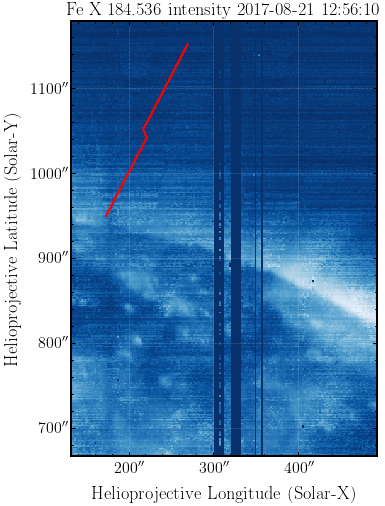

In [82]:
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(projection=fe_10_184_inten_map)
fe_10_184_inten_map.plot(axes=ax)
ax.plot(north_ch_eclipse_eis_pix[:,0],north_ch_eclipse_eis_pix[:,1],lw=2,color="red")

In [83]:
fe_10_184_intensity_ray = fe_10_184_inten_map.data[north_ch_eclipse_eis_pix[:,1],north_ch_eclipse_eis_pix[:,0]]
fe_10_184_intensity_ray_coord = fe_10_184_inten_map.wcs.pixel_to_world(north_ch_eclipse_eis_pix[:,0]*u.pix,
                                                                       north_ch_eclipse_eis_pix[:,1]*u.pix)


In [88]:
fe_10_intensity_ray_rsun_coord = np.sqrt(fe_10_184_intensity_ray_coord.Tx.value**2 + fe_10_184_intensity_ray_coord.Ty.value**2)/950

Text(0.5, 1.0, 'Fe \\textsc{x} 184 \\mbox{\\AA}')

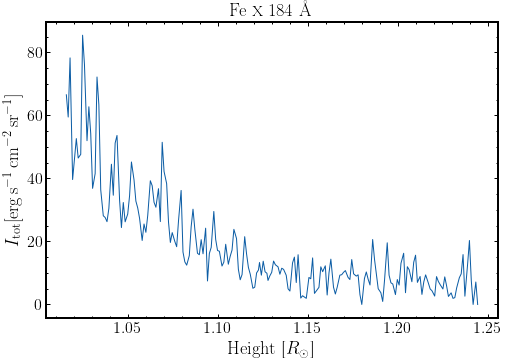

In [92]:
fig, ax = plt.subplots(figsize=(7,5),constrained_layout=True)
ax.plot(fe_10_intensity_ray_rsun_coord, fe_10_184_intensity_ray)
ax.set_xlabel(r"Height [$R_\odot$]",fontsize=18)
ax.set_ylabel(r"$I_{\rm tot} \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=18)
ax.set_title(r"Fe \textsc{x} 184 \mbox{\AA}",fontsize=18)

In [32]:
data_FeXII_195 = np.zeros_like(data_cube_FeXII_195.data)

In [33]:
for ii in range(180):
    data_FeXII_195[:,ii,:] = interp_window_slit_tilt(data_cube_FeXII_195.data[:,ii,:],data_cube_FeXII_195.wavelength[:,ii,:])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


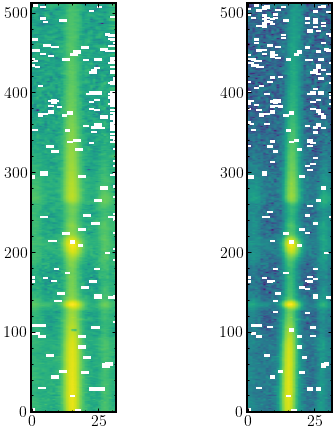

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,6),constrained_layout=True)
ax1.imshow(np.log10(data_FeXII_195[:,40,:]),origin="lower",aspect=0.3)
ax2.imshow(np.log10(data_cube_FeXII_195.data[:,40,:]),origin="lower",aspect=0.3)

In [35]:
data_FeXII_195_mask = copy.deepcopy(data_FeXII_195)
data_FeXII_195_mask[np.where(data_FeXII_195_mask < -100)] = np.nan

FeXII_195_slice = slice(5,25)
FeXII_195_bin = np.nanmean(data_FeXII_195_mask[:,:,FeXII_195_slice].reshape(-1,16,180,20),axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [36]:
FeXII_195_bin_model = SpectrumFit2D(FeXII_195_bin,data_cube_FeXII_195.wavelength[0,:,FeXII_195_slice],line_number=1,
                            line_wvl_init=[195.1],int_max_init=200,int_cont_init=0,fwhm_init=0.07,same_width=False)
FeXII_195_bin_model.run_lse_mp(ncpu=1,prev_init=False,absolute_sigma=False)

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Doppler velocity corrected by the median of each raster.
Instrumental width corrected.


/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:1510: RuntimeWarning: invalid value encountered in sqrt
  data_to_plot = np.sqrt(data_to_plot**2 - inst_width[:,np.newaxis]**2)


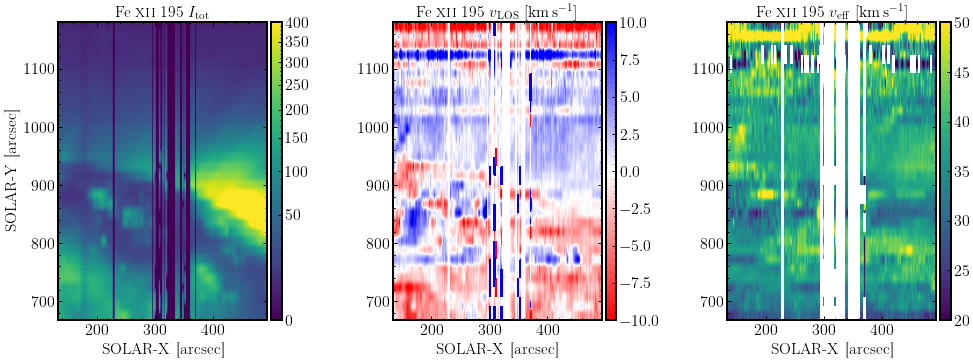

In [37]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,5),constrained_layout=True)
FeXII_195_bin_model.plot_fit2d(param="int",extent=data_cube_FeXII_195.meta["extent_arcsec"],vmin=0,vmax=400,
                    ax=ax1,title=r"Fe \textsc{xii} 195 $I_{\rm tot}$",scale="sqrt",ylabel=r"SOLAR-Y [arcsec]",
                    xlabel=r"SOLAR-X [arcsec]")
FeXII_195_bin_model.plot_fit2d(param="vel",extent=data_cube_FeXII_195.meta["extent_arcsec"],vmin=-10,vmax=10,
                    ax=ax2,ref_wvl=195.119,title=r"Fe \textsc{xii} 195 $v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}$",
                    xlabel=r"SOLAR-X [arcsec]")
FeXII_195_bin_model.plot_fit2d(param="veff",extent=data_cube_FeXII_195.meta["extent_arcsec"],vmin=20,vmax=50,
                    ax=ax3,ref_wvl=195.119,inst_width=inst_width_bin[:],
                    title=r"Fe \textsc{xii} 195 $v_{\rm eff}\ \mathrm{[km\,s^{-1}]}$",
                    xlabel=r"SOLAR-X [arcsec]")